In [1]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(repr)
library(DBI)
library(dbplyr)
library(RPostgres)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# DSCI 100 Group Project Proposal
## Group 8: Mikki, Muhammed, Tony Daisy 

### Introduction

We will be using the multivaraible Heart Disease Data in the UCI Machine Learing Repository (1988) to predict the presence of cardiovascular disease. At varying strengths, there are a multitude of factors that correlate with cardiovascular idsease onset, such as resting blood pressure and cholestrol levels of patients (Asia Pacific Cohot Studies Collaboration, 2005). Therefore, we have chose to explore the relationship between cardivascular disease and these two variables. We hope to determine whether a patient's cholestral levels and blood pressure can predict the presence of cardiovascular disease. 

### Preliminary Explanatory Data Analysis

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,trestbps,cvd,age,sex
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
286,160,2,67,1
229,120,1,67,1
236,120,0,56,1
268,140,3,62,0
354,120,0,57,0
254,130,2,63,1


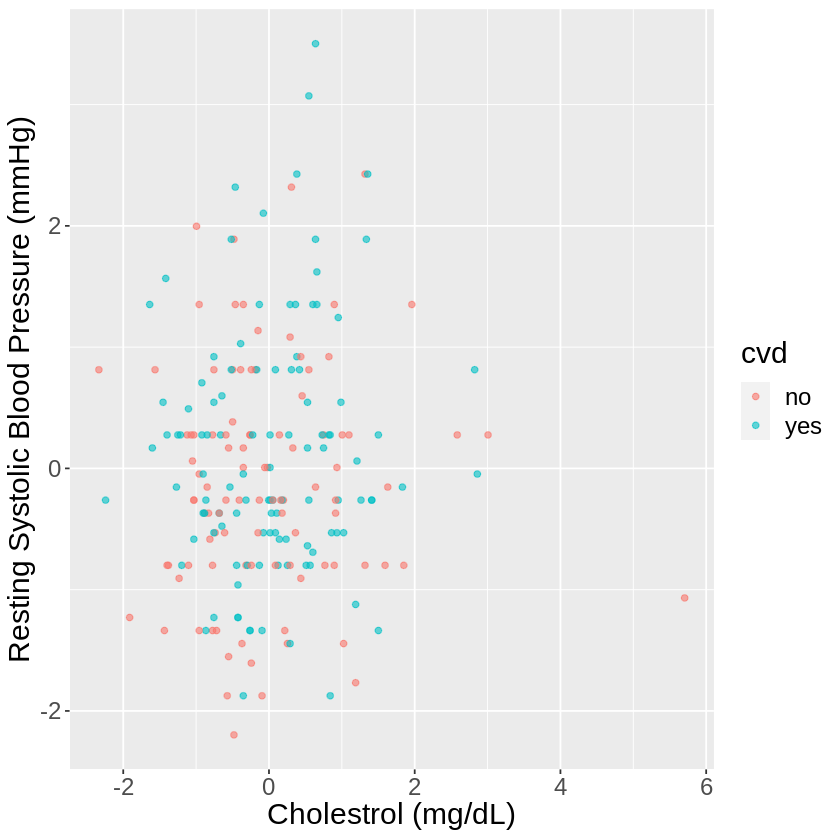

In [3]:
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data_raw<-read_csv(url)
colnames(heart_data_raw)<- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "cvd")
heart_data<-heart_data_raw %>%
    select(chol, trestbps, cvd, age, sex)%>%
    filter(age>50)
head(heart_data)
heart_data$cvd[heart_data$cvd == "2"] <- "1"
heart_data$cvd[heart_data$cvd == "3"] <- "1"
heart_data$cvd[heart_data$cvd == "4"] <- "1"
heart_data$cvd[heart_data$cvd == "1"] <- "yes"
heart_data$cvd[heart_data$cvd == "0"] <- "no"

#split data into training part and testing part
hd_split<- initial_split(heart_data,prop=0.75, strata = cvd)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)
#preprocesss data
hd_recipe <- recipe(cvd~chol+trestbps,data = heart_data)|>
step_scale(all_predictors())|>
step_center(all_predictors())|>
prep()
scaled_hd<- bake(hd_recipe,heart_data)

#i changed title of num to cvd, and replaced all values indication presence of cvd with yes or no
heart_data_plot_male<-scaled_hd %>%
    ggplot(aes(x = chol , y = trestbps , color = cvd)) +
    geom_point(alpha = 0.6) +
    labs(x = "Cholestrol (mg/dL)" , y = "Resting Systolic Blood Pressure (mmHg)") +
    theme(text = element_text(size = 18))
heart_data_plot_male
#may come back and make cvd into factor or lgl vector .

### Methods

(from mikki: include standardizing data, colour coding for and predicting presence of c.dis. using knn, could include lines on graph that show where average or healthy rates are as well. also cross validation of k values, and compare whether both varaivles or one of these two on their own would better predict the presence. )) 

### Predictions and Significance

We have decided to use cholestrol and blood pressure as our predictive varaibles because previous research has depicted a significant relationship between cardiovascular disease and significant changes in both these factors (Asia Pacific Cohot Studies Collaboration, 2005). Specifically, the aformentioned study found a steep relationship between cholestrol levels and cardiovascualr disease onset. Unnatural cholestrol levels have also been correlated with coronary heart disease deaths (BMJ, 2009) showing the potential severity of fluctuating cholestrol levels on the circulatory system. High blood pressure levels have also been correlated with cardiovascular disease (D., Flavio Fushs, 2019).
    Therefore, we predict a significant relationship between both high blood pressure and cholestrol to the presence of cardiovascular disease in patients. 

### Citations

    Citations
   Asia Pacific Cohort Studies Collaboration, Nov 21st (2005), Joint Effectos of Systolic Blood Pressure and Serum Cholestrol on Cardiovascular Disease in the Asia Pacific Region, 112:3384-3390, https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.105.537472
   BMJ, Feb 16th (2009), Assicoation between Change in High Density Lipoprotein Cholestrol and Cardiovascular Disease Morbidity and Mortality: Systematic Review and Meta-regression Analysis, 338;b92
https://www.bmj.com/content/338/bmj.b92.short
    D., Flavio Fuchs, Whelton, Paul K., Dec 23rd (2019), High Blood Pressure and Cardiovascular Disease, Hypertension, 75:285-292, https://www.ahajournals.org/doi/full/10.1161/HYPERTENSIONAHA.119.14240
   UCI Machine Learning Repository, (1988), Heart Disease Data Set,
https://archive.ics.uci.edu/ml/datasets/Heart+Disease
